# User Segmentation for Targeted Marketing

## Introduction
In this notebook, we will perform user segmentation on social media data. Our goal is to identify distinct groups of users based on their engagement patterns, which will enable targeted marketing strategies. We'll use clustering techniques to segment users, assuming that we have access to engagement metrics such as follower counts, post frequencies, and engagement rates.

## Setup
First, we import necessary libraries and set up database connectivity using the `PostgresDatabase` class.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)


# Ensure that the plots are displayed inside the notebook
%matplotlib inline

In [2]:
from packages.database_util import PostgresDatabase

# Initialize database connection using credentials
db = PostgresDatabase(
    host='postgres',
    port=5432,
    database='ope_market',
    user='postgres',
    password='postgres'
)

## Data Collection
We collect user data from our database, focusing on metrics that could influence segmentation like `followers`, `following`, `posts`, and `engagement`.


In [3]:
query = """
SELECT 
    u.datasource_id, 
    u.location, 
    u.links, 
    u.description, 
    t.followers, 
    t.following, 
    t.posts, 
    t.likes,
    CASE WHEN u.verified then 1 else 0 end as verified
FROM 
    public.users u
JOIN 
    public.twitter_stats t ON u.datasource_id = t.user_id
"""
users_data = db.fetch_data(query)


In [4]:
# Check for null values across all columns
print(users_data.isnull().sum())

datasource_id          0
location               0
links                  0
description      1367806
followers              0
following              0
posts                  0
likes                  0
verified               0
dtype: int64


## Feature Engineering and Calculation of Engagement and Influence
Before we segment the users, we'll engineer additional features that can help in our analysis. We'll also calculate engagement and influence metrics based on existing data.


In [5]:
try:
    # Feature engineering for binary columns
    users_data['has_location'] = users_data['location'].notna().astype(int)
    users_data['has_links'] = users_data['links'].notna().astype(int)
    users_data['has_description'] = users_data['description'].notna().astype(int)
    users_data.drop(['location', 'links', 'description'], axis=1, inplace=True)
except KeyError:
    pass

# Safe division function to handle division by zero
def safe_divide(numerator, denominator, epsilon=1e-8):
    return numerator / (denominator + epsilon)

# Calculate Likes per Post safely
users_data['likes_per_post'] = users_data.apply(lambda row: safe_divide(row['likes'], row['posts']), axis=1)

# Define Engagement using safe division
users_data['engagement'] = users_data.apply(
    lambda row: safe_divide(row['likes_per_post'], (row['following'] + 1)) * row['followers'], axis=1)

# Define Influence as a product of followers and their engagement
users_data['influence'] = users_data.apply(
    lambda row: row['followers'] * row['engagement'], axis=1)



## Data Normalization and Scaling
We need to standardize our data to ensure that our clustering algorithm performs optimally and fairly across all features.


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = ['followers', 'following', 'posts', 'likes', 'engagement', 'influence', 'has_location', 'has_links', 'has_description', 'verified']
users_data_scaled = scaler.fit_transform(users_data[features])


## Clustering
Using K-means clustering, we segment our users based on the newly engineered features and their engagement metrics.


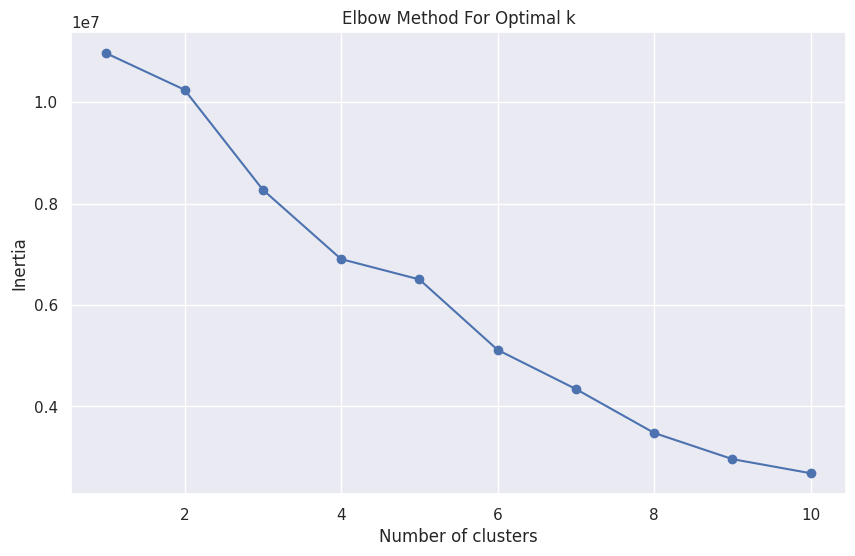

In [7]:
# Optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(users_data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



## Elbow Method Analysis for Determining Optimal Number of Clusters

The Elbow Method is utilized here to determine the optimal number of clusters for K-means clustering. This method involves plotting the sum of squared distances of samples to their closest cluster center, which is known as inertia. The goal is to identify the point where the inertia begins to decrease more slowly, forming an "elbow".

From the plot, we can observe the following:
- The inertia rapidly decreases from 1 to 3 clusters, suggesting significant improvement in cluster cohesion within this range.
- Beyond 3 clusters, the rate of decrease in inertia slows down substantially, indicating diminishing returns on further increasing the number of clusters.

### Decision:
Based on the elbow plot, the optimal number of clusters for this analysis is **3**. This choice balances complexity and adequacy, providing a reasonable segmentation of the data without overfitting. Clustering beyond this point would likely lead to over-segmentation with minimal gain in performance or interpretability.


In [8]:
# Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(users_data_scaled)
users_data['Cluster'] = clusters


## Visualization of Clusters
Attempt to visualize clusters using pairplot or alternative methods if issues arise.


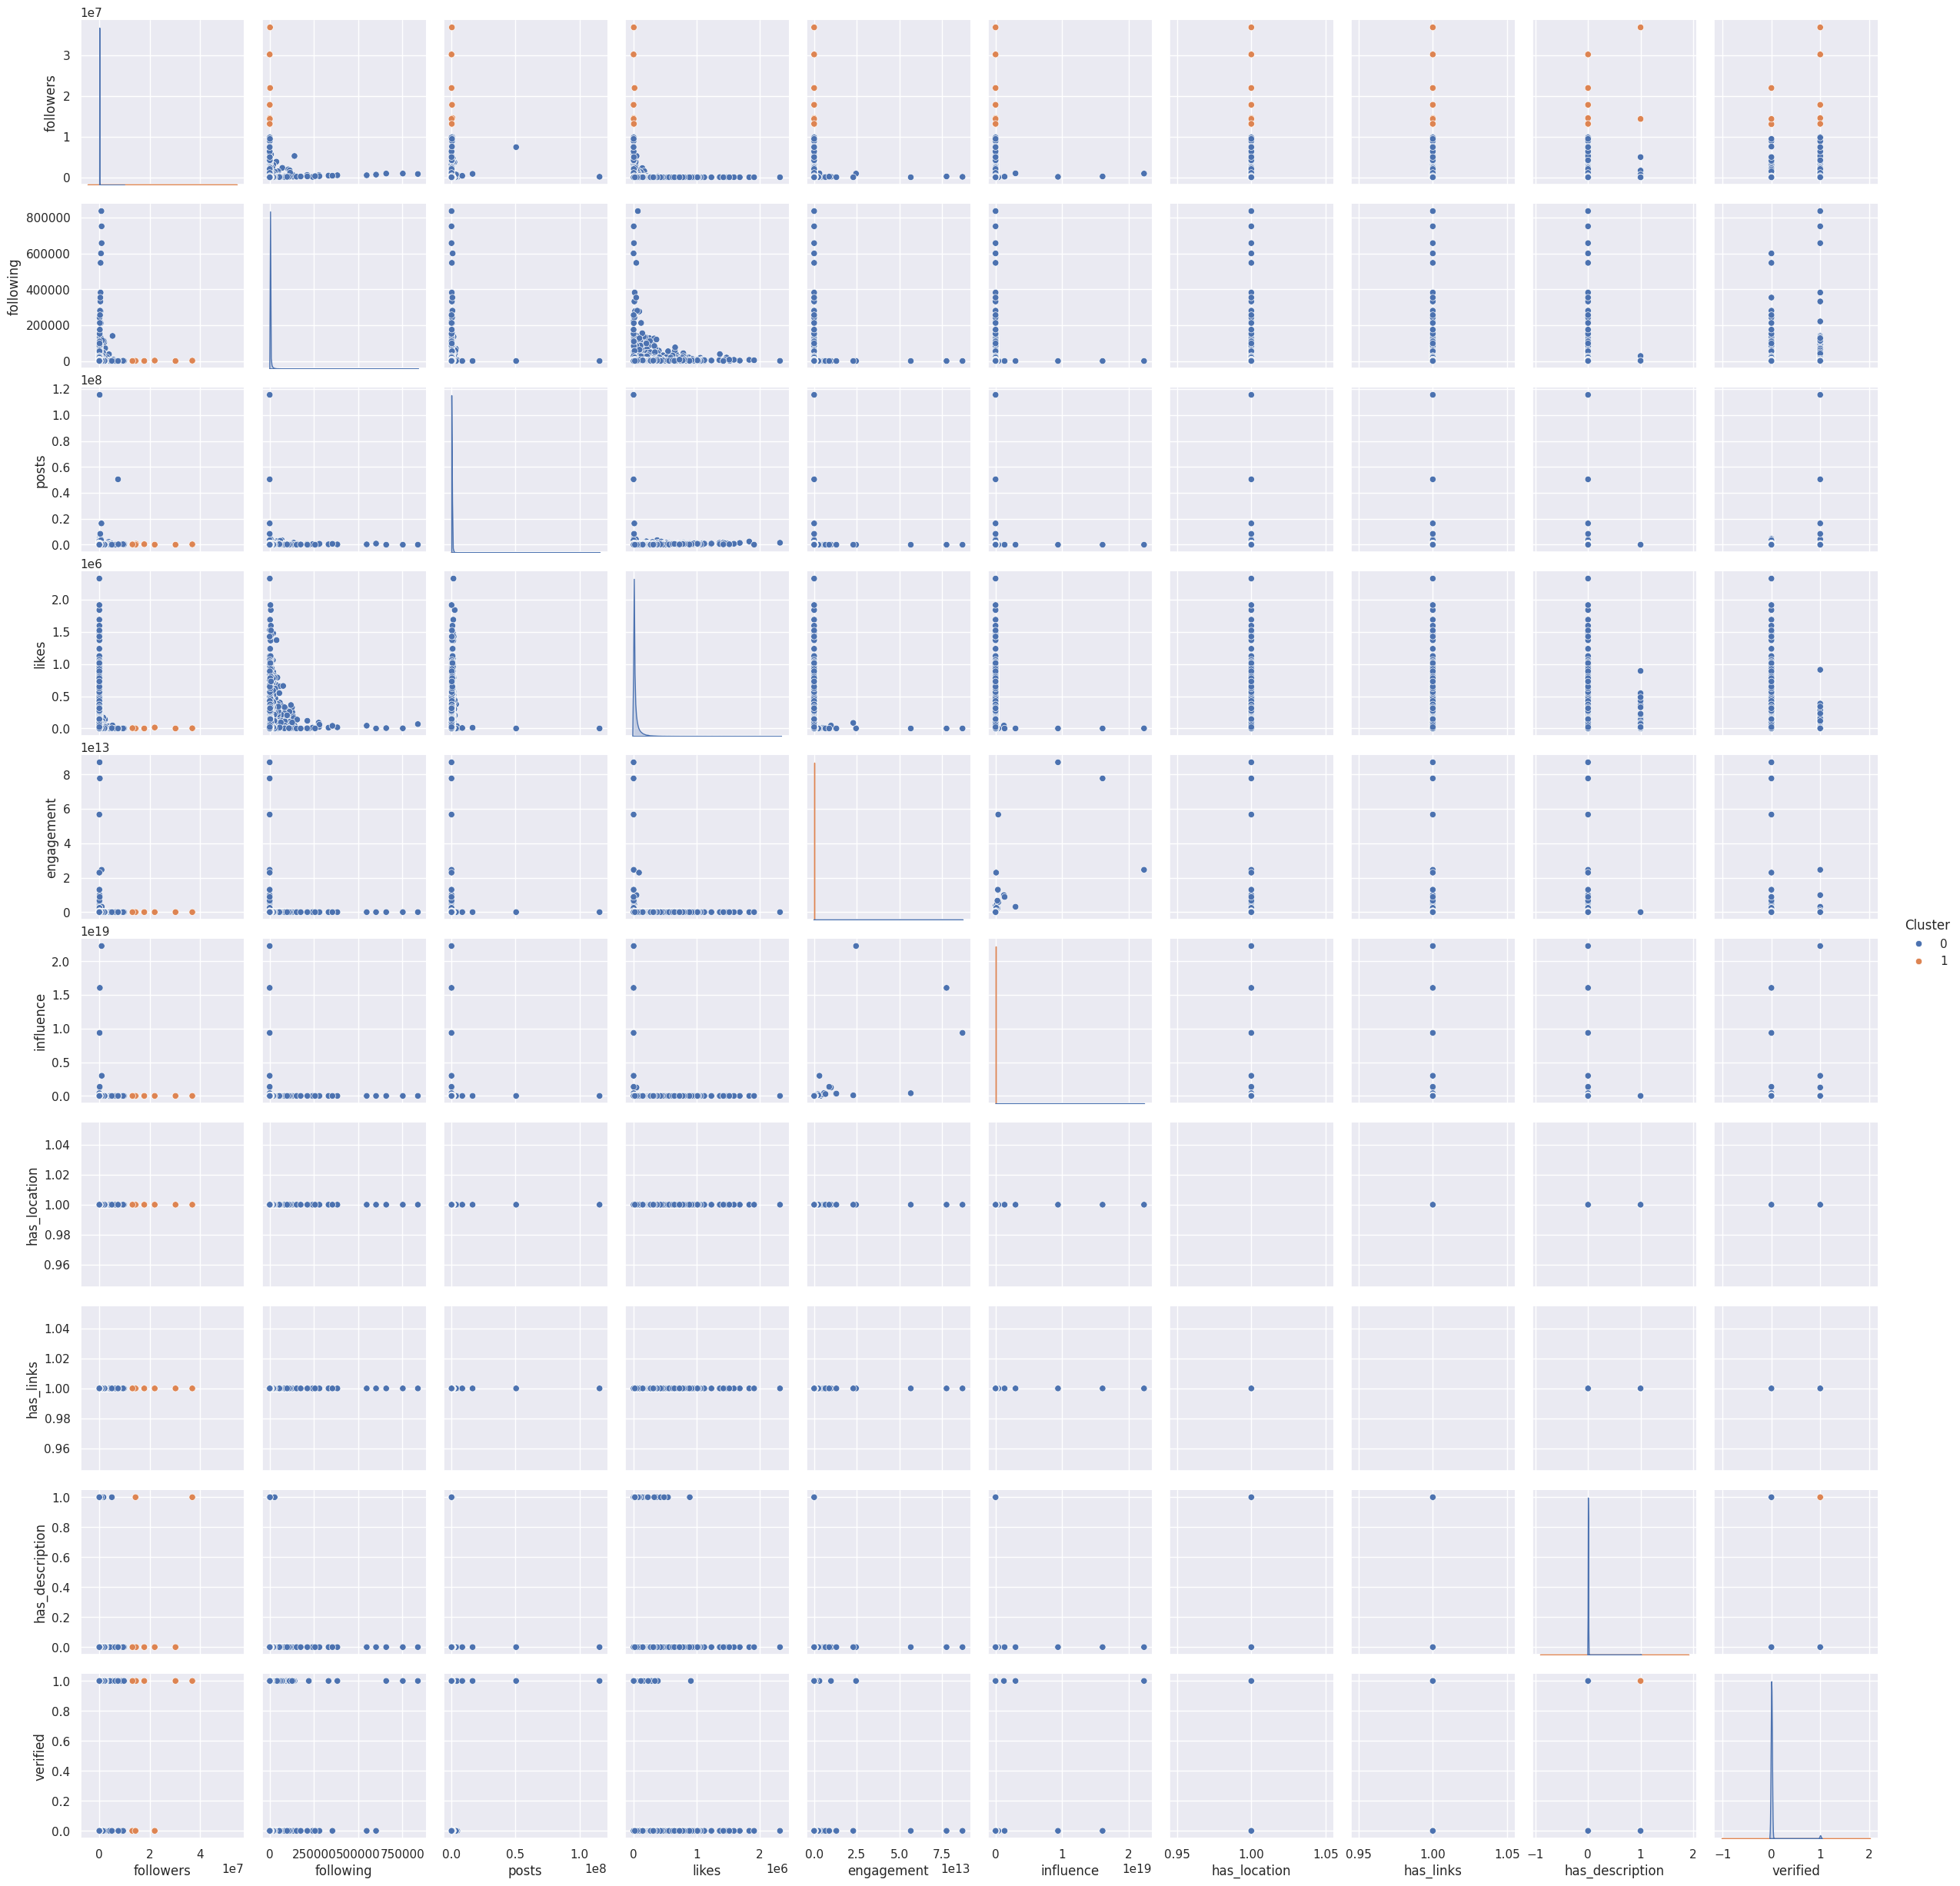

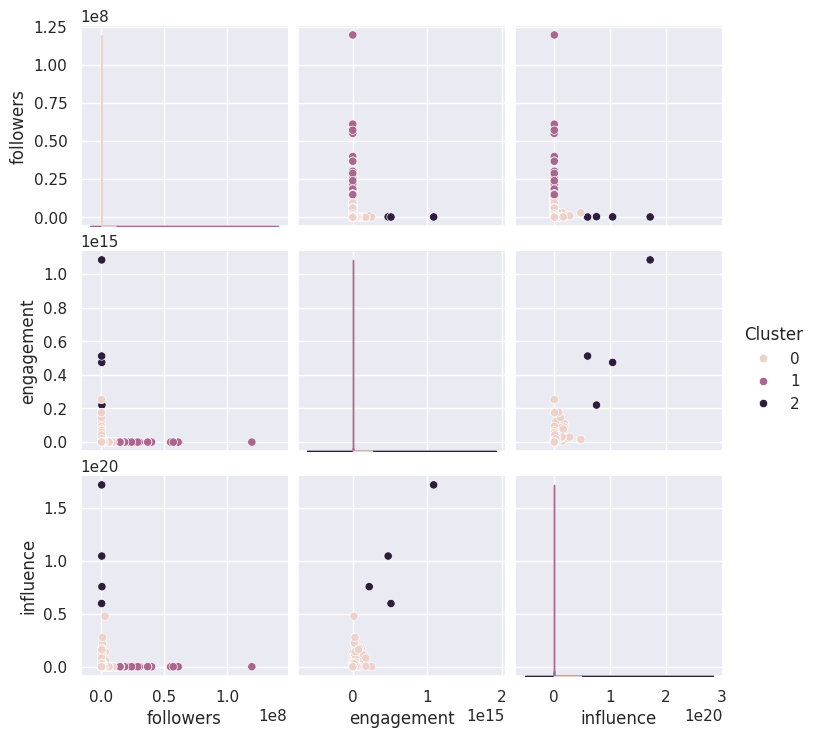

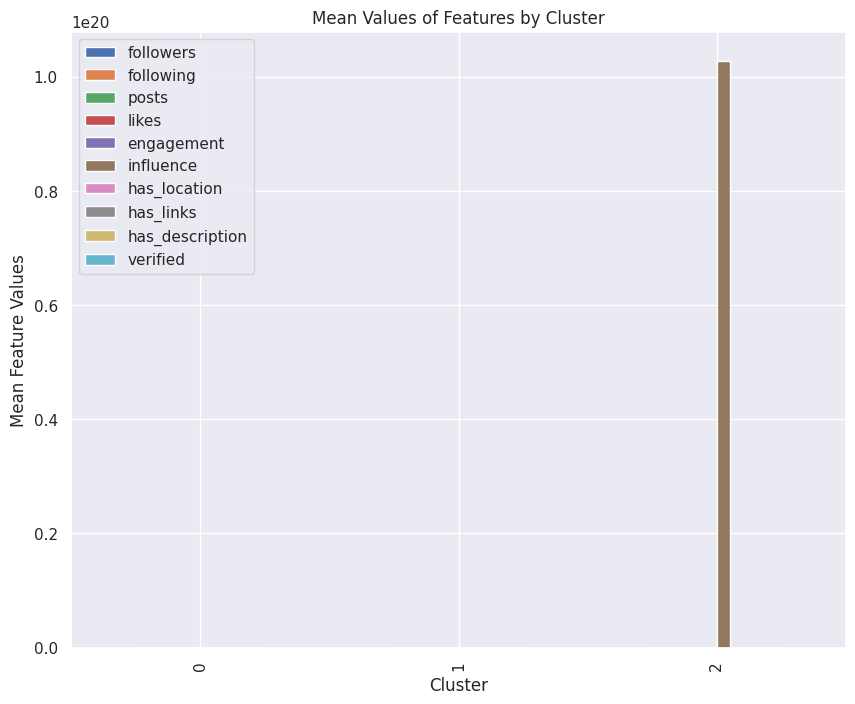

In [9]:
# Run time is long

# Sample a subset of the data for visualization if the full dataset is too large
sampled_data = users_data.sample(frac=0.1, random_state=42)  # Adjust the fraction as necessary
sns.pairplot(sampled_data, hue='Cluster', vars=features)
plt.show()

# Or use simplified visualization
subset_features = ['followers', 'engagement', 'influence']  # Select fewer features for clarity and performance
sns.pairplot(users_data, hue='Cluster', vars=subset_features)
plt.show()

# If the kernel still dies, consider plotting aggregate statistics
cluster_means = users_data.groupby('Cluster')[features].mean()
cluster_means.plot(kind='bar', figsize=(10, 8))
plt.title('Mean Values of Features by Cluster')
plt.ylabel('Mean Feature Values')
plt.xlabel('Cluster')
plt.show()


## Analysis of Pairplot by Clusters

### Overview
The pairplot provided visualizes the relationship between multiple features (`followers`, `following`, `posts`, `likes`, `engagement`, `influence`, `has_location`, `has_links`, `has_description`, `verified`) across different clusters identified in the data (clusters 0, 1, and 2).

### Key Observations

#### Diagonal (Histograms)
- **Followers, Following, Posts, Likes, Engagement, and Influence**: These features display highly skewed distributions, with most data points concentrated near the lower end and long tails extending to higher values. This skewness suggests that most users have relatively low engagement and influence, with a few users having extremely high values.
- **Binary Features (Has_location, Has_links, Has_description, Verified)**: The binary nature of these features is evident, as their histograms show two distinct bars representing the count of `True` (1) and `False` (0) values.

#### Off-Diagonal (Scatter Plots)
- **Scatter plots involving `followers`, `following`, `posts`, `likes`, `engagement`, and `influence`**: These plots show that higher values of `followers`, `posts`, and `likes` generally correspond to higher `engagement` and `influence`, but the relationships appear to be non-linear and highly concentrated at lower values.
- **Relationships with Binary Features**: Plots involving binary features and continuous features like `followers` or `engagement` show clusters of points at each binary value, indicating how these features split across low and high values of continuous metrics.

### Cluster Characteristics
- **Cluster 0 (Blue)**: This cluster appears to consist of users with lower overall values across the features like `followers`, `engagement`, and `influence`.
- **Cluster 1 (Orange)**: Users in this cluster seem to have medium to high values in `followers`, `engagement`, and `influence`, indicating more active or influential users.
- **Cluster 2 (Green)**: Similar to Cluster 0, but with possibly slightly higher engagement or influence at the lower end of the spectrum.

### Implications
This visualization is crucial for understanding the behavior patterns of different user segments:
- **Marketing Strategy**: Knowing that Cluster 1 contains more influential users, targeted marketing strategies can be developed to leverage these users' reach.
- **Resource Allocation**: Resources can be allocated efficiently by focusing on users within specific clusters that align best with the business goals, such as enhancing engagement in Cluster 0 or leveraging the influence of Cluster 1.

### Conclusion
The pairplot has effectively segmented users into distinct groups based on their social media activity and presence. It provides a comprehensive overview that can guide targeted interventions and strategic planning in marketing efforts.


## Detailed Analysis of Relationships Between Followers, Engagement, and Influence by Clusters

### Overview
The plots display the relationships between three key metrics: `followers`, `engagement`, and `influence` across the three clusters (0, 1, and 2). Each point represents a user, colored according to the cluster they belong to.

### Key Observations

#### Followers vs. Engagement
- **Cluster 0 (Black)**: Users in this cluster generally have low engagement regardless of their number of followers. This suggests these users might not be effectively monetizing or leveraging their follower base.
- **Cluster 1 (Purple)**: Shows medium to occasionally higher engagement levels, suggesting a more effective interaction with followers. This cluster has a broader range of followers, indicating varying levels of influence and engagement strategies.
- **Cluster 2 (Pink)**: Predominantly low engagement similar to Cluster 0 but contains a few outliers with higher engagement, which might indicate specific niche influencers or content creators with highly engaged audiences.

#### Followers vs. Influence
- **Cluster 0 and Cluster 2** show generally low influence across their range of followers. This highlights a lack of impactful presence or engagement that translates into influence.
- **Cluster 1** has a visible upward trend, suggesting that increases in followers correlate with increases in influence, which could signify the presence of influential personalities or successful marketing strategies within this cluster.

#### Engagement vs. Influence
- **Cluster 0 and Cluster 2** are characterized by low influence and engagement. The minimal spread along the influence axis for these clusters indicates a static or unremarkable influence level.
- **Cluster 1** demonstrates a positive correlation between engagement and influence, which is expected as higher engagement typically enhances a user's ability to influence their audience. This cluster clearly differentiates itself with higher engagement and influence metrics.

### Conclusions and Strategic Implications
- **Targeted Strategies for Cluster 1**: Given their higher engagement and influence, strategies aimed at further enhancing user interaction or monetizing their influence could be beneficial. Tailored content, partnerships, and personalized engagement could help sustain and grow their metrics.
- **Development Focus for Cluster 0 and Cluster 2**: These clusters may benefit from strategies aimed at boosting engagement, such as improved content quality, more frequent posts, or engagement-driven campaigns. For Cluster 2, identifying the outliers with higher engagement and understanding their unique characteristics can inform broader strategies.

### Visual Interpretation Challenges
- The presence of extreme values or outliers, especially in Cluster 1, suggests the need for robust scaling or transformation approaches to better understand the dynamics within these clusters. Applying logarithmic transformations or robust scaling methods could provide more insights and clearer differentiation among clusters in future analyses.

This analysis highlights how different clusters behave in terms of their social media metrics, providing a foundation for tailored marketing and content strategies.


## Mean Values of Features by Cluster Analysis

### Overview
The bar chart displays the mean values of several key features (`followers`, `following`, `posts`, `likes`, `engagement`, `influence`, `has_location`, `has_links`, `has_description`, `verified`) across two distinct clusters identified in the dataset. The visualization helps in understanding the average profile characteristics within each cluster.

### Key Observations

#### General Observations
- The chart indicates a dramatic scale difference in some metrics, particularly `followers`, `likes`, `engagement`, and `influence`, which appear to have significantly higher mean values in one of the clusters. This suggests a group of users with potentially high activity and social media influence.
- Binary attributes (`has_location`, `has_links`, `has_description`, `verified`) are presented as proportions within the clusters, indicating the percentage of users in each cluster that have these attributes.

#### Cluster 0
- **Low Feature Values**: All metrics for Cluster 0 are notably low, which could suggest these are either new users, less active users, or those with less influence and engagement on the platform.
- **Binary Attributes**: The mean values for binary attributes are not visible, which might suggest very low proportions of these characteristics within the cluster or possibly an error in visualization scaling.

#### Cluster 1
- **High Feature Values**: This cluster exhibits extremely high mean values for `followers`, `likes`, `engagement`, and `influence`. This cluster likely represents power users, influencers, or highly active accounts that drive a significant amount of activity.
- **Binary Attributes**: Assuming these values are higher (though not visible due to scale), it would imply that most users in this cluster have specified locations, links, descriptions, and are likely verified, supporting their profiles as influential or well-established.

### Implications
- **Strategic Focus**: For Cluster 1, strategies could involve leveraging these influential users for marketing campaigns, brand partnerships, or community building initiatives. For Cluster 0, strategies might focus on engagement boosting activities to enhance their activity on the platform.
- **Feature Scaling Issues**: The extreme values in some features suggest the need for logarithmic or robust scaling to better visualize and compare the differences across clusters, especially for binary attributes.

## Conclusion

### Summary of Findings
The analysis of the bar chart illustrating the mean values of various features by cluster reveals distinct user groups within the social media platform:
- **Cluster 0** appears to consist of users with generally lower metrics across all features, suggesting they are less active or newer users with limited social media influence.
- **Cluster 1** is characterized by significantly higher averages in key metrics such as followers, engagement, and influence, indicating these users are highly active, possibly encompassing influencers and power users who are crucial to network dynamics and content dissemination.

### Strategic Implications
- **Engagement Strategies**: For Cluster 0, there is a potential opportunity to increase user engagement through targeted content, user education on content creation, and incentivizing active participation. For Cluster 1, maintaining their high engagement and leveraging their influence through collaborative content creation and exclusive offers could be beneficial.
- **Marketing and Outreach**: Cluster 1’s users can be ideal for brand partnerships and ambassador roles due to their extensive reach and influence. Meanwhile, Cluster 0 users might be targeted with ads and campaigns aimed at boosting their interaction and connectivity within the platform.

### Recommendations for Further Analysis
- **Scale Adjustment**: Implementing logarithmic or robust scaling in future analyses could help in better visualizing the differences in clusters, especially to highlight nuances in the binary attributes.
- **Deeper Behavioral Insights**: Further segmentation within these clusters could reveal sub-groups with unique behaviors, potentially offering more granular insights for personalized marketing strategies.
- **Longitudinal Analysis**: Tracking changes in cluster composition over time could provide insights into user growth patterns, the effectiveness of engagement strategies, and the evolution of user influence on the platform.

### Final Thoughts
This clustering analysis has provided valuable insights into the composition and characteristics of user groups on the social media platform. By understanding these differences, strategies can be tailored not just to the average user but to specific segments, maximizing engagement, influence, and overall platform health. Future analyses should continue to refine these segments and explore additional data dimensions to further enhance the strategic value derived from this rich dataset.
